# Predicción de Riesgo de Enfermedad Cardíaca

En este notebook construiremos un modelo de regresión logística para predecir `HeartDiseaseorAttack` usando un pipeline completo que incluye:

1. Carga y EDA  
2. Ingeniería de features (Age buckets, binarización de salud y diabetes, interacciones)  
3. Preparación de datos (one-hot, escalado)  
4. Modelo Baseline (todas las features raw)  
5. Tres iteraciones de selección (Heatmap, Coeficientes, IV)  
6. Modelo final y conclusiones  

---

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, roc_auc_score, roc_curve
)

RANDOM_STATE = 47
pd.set_option('display.max_columns', None)


In [38]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Matriz de Confusión'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes); plt.yticks(ticks, classes)
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]:d}",
                 ha='center', va='center',
                 color='white' if cm[i,j] > thresh else 'black')
    plt.ylabel('Etiqueta verdadera'); plt.xlabel('Etiqueta predicha')
    plt.tight_layout(); plt.show()

## 2. Carga del dataset  
Leemos el CSV descargado al path local. 

In [39]:
df = pd.read_csv('/Users/josetanchez/Desktop/heart_disease_health_indicators_BRFSS2015.csv')
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### 2.1 Información y estadísticos básicos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

,count,mean,std,min,25%,50%,75%,max
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
Diabetes,253680.0,0.296921,0.698160,0.0,0.0,0.0,0.0,2.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


Valores nulos por columna:
 HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


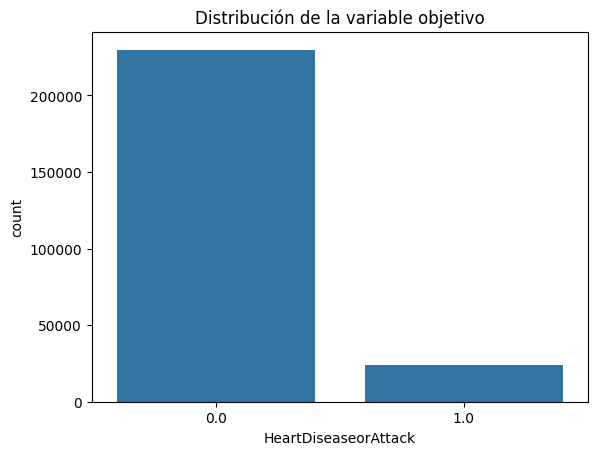

In [40]:
df.info()
display(df.describe().T)
print("Valores nulos por columna:\n", df.isna().sum())
sns.countplot(x='HeartDiseaseorAttack', data=df)
plt.title('Distribución de la variable objetivo')
plt.show()

## 3. Ingeniería de Features  
Creamos nuevas variables basadas en tus criterios:

- **Age_group:** 3 buckets `<45`, `45–64`, `65+`  
- **Diabetes_bin:** 0 vs pre/diabetes+diabetes  
- **GenHlth_bad, MentHlth_bad, PhysHlth_bad:** indicadores binarios de salud mala ≥14 días o mala percepción  
- **BP_Chol:** HighBP × HighChol  
- **Smoker_noAct:** fuma y no realiza actividad física  

In [ ]:
df['Age_group'] = pd.cut(
    df['Age'],
    bins=[0,5,9,13],
    labels=['<45','45-64','65+']
)

df['Diabetes_bin'] = df['Diabetes'].apply(lambda x: 1 if x >= 1 else 0)

df['GenHlth_bad']  = df['GenHlth'].apply(lambda x: 1 if x >= 4 else 0)
df['MentHlth_bad'] = df['MentHlth'].apply(lambda x: 1 if x >= 14 else 0)
df['PhysHlth_bad'] = df['PhysHlth'].apply(lambda x: 1 if x >= 14 else 0)

df['BP_Chol']      = df['HighBP'] * df['HighChol']
df['Smoker_noAct'] = df['Smoker'] * (1 - df['PhysActivity'])

df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Age_group,Diabetes_bin,GenHlth_bad,MentHlth_bad,PhysHlth_bad,BP_Chol,Smoker_noAct
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,45-64,0,1,1,1,1.0,1.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,45-64,0,0,0,0,0.0,0.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,45-64,0,1,1,1,1.0,0.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,65+,0,0,0,0,0.0,0.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,65+,0,0,0,0,1.0,0.0


## 4. Preparación de X e Y  
- **Baseline:** X_raw = todas las features originales (sin ingeniería)  
- **X_eng:** features con dummies + nuevas variables  

In [ ]:
X_raw = df.drop('HeartDiseaseorAttack', axis=1)
y      = df['HeartDiseaseorAttack']

X_eng = pd.get_dummies(
    df.drop('HeartDiseaseorAttack', axis=1),
    columns=['Age_group'],
    drop_first=True
)

for col in ['Diabetes_bin','GenHlth_bad','MentHlth_bad','PhysHlth_bad','BP_Chol','Smoker_noAct']:
    X_eng[col] = df[col]

X_eng.shape, X_raw.shape

((253680, 29), (253680, 28))

## 5. Modelo Baseline (todas las features raw)  
Evaluamos un logistic regression sin ningún tratamiento especial.

In [ ]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_raw, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

baseline = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
baseline.fit(Xb_train, yb_train)

yb_pred  = baseline.predict(Xb_test)
yb_proba = baseline.predict_proba(Xb_test)[:,1]

def ks_stat(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return np.max(tpr - fpr)

def eval_model(y_true, y_pred, y_proba):
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("ROC AUC  :", roc_auc_score(y_true, y_proba))
    print("KS       :", ks_stat(y_true, y_proba))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

print("=== Baseline (raw features) ===")
eval_model(yb_test, yb_pred, yb_proba)

=== Baseline (raw features) ===
Accuracy : 0.9085067801955219
Precision: 0.5622343655130541
Recall   : 0.12918526785714285
ROC AUC  : 0.8482834421617386
KS       : 0.543828016203435
Confusion matrix:
 [[68215   721]
 [ 6242   926]]


## 6. Preparación de `X_eng`: One-Hot y Split + Escalado

En esta sección convertimos `Age_group` en dummies, mantenemos todas las demás features (incluidas las nuevas binarias e interacciones), y luego dividimos en train/test y escalamos las variables continuas.

In [ ]:
X_eng = pd.get_dummies(
    df.drop('HeartDiseaseorAttack', axis=1),
    columns=['Age_group'],
    drop_first=True
)

for col in ['Diabetes_bin','GenHlth_bad','MentHlth_bad','PhysHlth_bad','BP_Chol','Smoker_noAct']:
    X_eng[col] = df[col]

print("Columnas de X_eng:", [c for c in X_eng.columns if 'Age_group' in c])

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_eng, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

cont_feats = ['BMI','MentHlth','PhysHlth']
scaler = StandardScaler()
X_train_e[cont_feats] = scaler.fit_transform(X_train_e[cont_feats])
X_test_e[cont_feats]  = scaler.transform(X_test_e[cont_feats])

print("Train shape:", X_train_e.shape, "Test shape:", X_test_e.shape)

Columnas de X_eng: ['Age_group_45-64', 'Age_group_65+']
Train shape: (177576, 29) Test shape: (76104, 29)


## 7. Iteración 1: Subset por Heatmap de Correlación  
Seleccionamos las 10 features con mayor correlación promedio (valor absoluto) del **X_train_e** y entrenamos un LogisticRegression sobre ese subset.

Features seleccionadas (Heatmap): ['GenHlth', 'GenHlth_bad', 'PhysHlth', 'DiffWalk', 'PhysHlth_bad', 'Income', 'BP_Chol', 'HighBP', 'Diabetes', 'Diabetes_bin']
=== Iteración 1: Heatmap ===
Accuracy : 0.7353227162829812
Precision: 0.21994388085473776
Recall   : 0.7107979910714286
ROC AUC  : 0.7939674816214755
KS       : 0.45184494041574796
Confusion matrix:
 [[50866 18070]
 [ 2073  5095]]


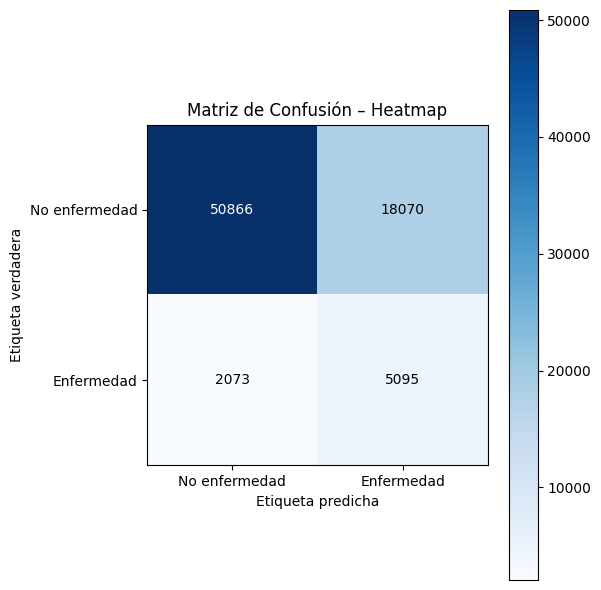

In [ ]:
heat_feats = (
    X_train_e
    .corr()
    .abs()
    .mean()
    .sort_values(ascending=False)
    .index
    .tolist()[:10]
)
print("Features seleccionadas (Heatmap):", heat_feats)

model_heat = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
model_heat.fit(X_train_e[heat_feats], y_train_e)

y_pred_h  = model_heat.predict(X_test_e[heat_feats])
y_proba_h = model_heat.predict_proba(X_test_e[heat_feats])[:,1]

print("=== Iteración 1: Heatmap ===")
eval_model(y_test_e, y_pred_h, y_proba_h)

plot_confusion_matrix(
    y_true=y_test_e,
    y_pred=y_pred_h,
    classes=['No enfermedad', 'Enfermedad'],
    title='Matriz de Confusión – Heatmap'
)

## Iteración 2: Subset por Importancia de Coeficientes  
Aquí entrenamos un Logistic Regression sobre **todas** las features para extraer los coeficientes absolutos, seleccionamos las 10 variables con mayor valor absoluto, y volvemos a entrenar solo con ese subset.

Features seleccionadas (Coeficientes): ['Stroke', 'Sex', 'HighChol', 'CholCheck', 'GenHlth', 'HighBP', 'Smoker', 'DiffWalk', 'HvyAlcoholConsump', 'NoDocbcCost']
=== Iteración 2: Coeficientes ===
Accuracy : 0.7493298643960895
Precision: 0.23501401806773176
Recall   : 0.7367466517857143
ROC AUC  : 0.8187284616800365
KS       : 0.4905486384109899
Confusion matrix:
 [[51746 17190]
 [ 1887  5281]]


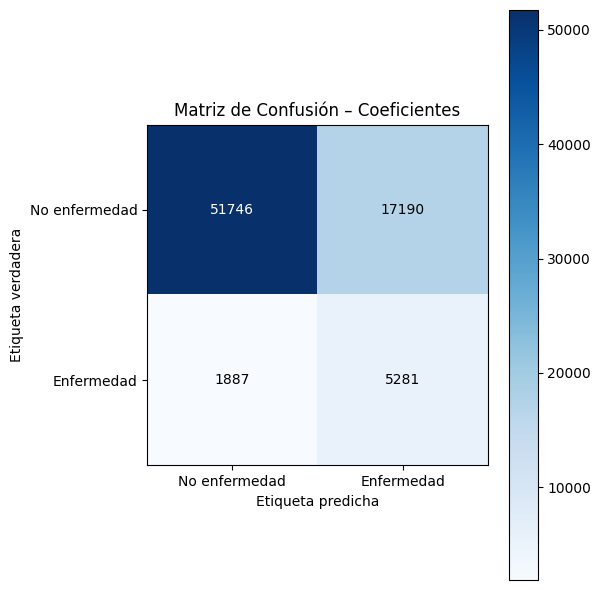

In [ ]:
coef_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
coef_model.fit(X_train_e, y_train_e)

coefs      = pd.Series(coef_model.coef_[0], index=X_train_e.columns)
coef_feats = coefs.abs().sort_values(ascending=False).head(10).index.tolist()
print("Features seleccionadas (Coeficientes):", coef_feats)

model_coef = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
model_coef.fit(X_train_e[coef_feats], y_train_e)

y_pred_c  = model_coef.predict(X_test_e[coef_feats])
y_proba_c = model_coef.predict_proba(X_test_e[coef_feats])[:,1]

print("=== Iteración 2: Coeficientes ===")
eval_model(y_test_e, y_pred_c, y_proba_c)

plot_confusion_matrix(
    y_true=y_test_e,
    y_pred=y_pred_c,
    classes=['No enfermedad','Enfermedad'],
    title='Matriz de Confusión – Coeficientes'
)

## Iteración 3: Subset por Information Value (IV)  
En esta última iteración calculamos el Information Value (IV) de las variables continuas `BMI`, `MentHlth` y `PhysHlth`, seleccionamos aquellas con IV > 0.02 y entrenamos un modelo usando solo ese subset.

IV Scores: {'BMI': 0.0501, 'MentHlth': 0.0251, 'PhysHlth': 0.2686}
Features seleccionadas (IV > 0.02): ['BMI', 'MentHlth', 'PhysHlth']
=== Iteración 3: IV ===
Accuracy : 0.780655418900452
Precision: 0.18747949340507908
Recall   : 0.39857700892857145
ROC AUC  : 0.6487405589433237
KS       : 0.22382173320181037
Confusion matrix:
 [[56554 12382]
 [ 4311  2857]]


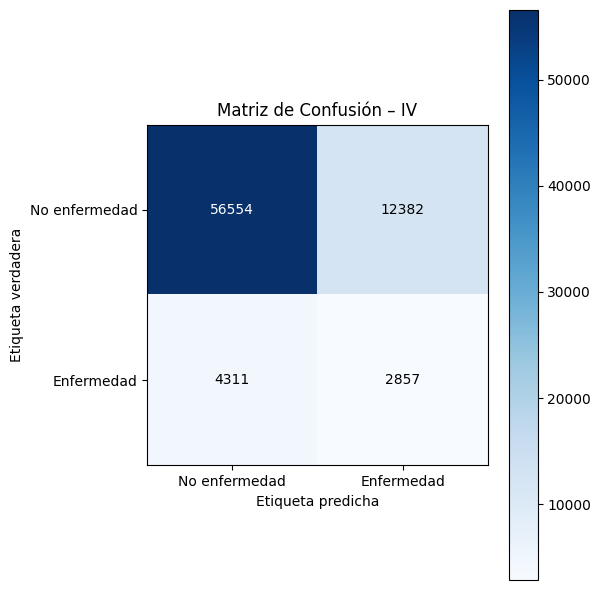

In [ ]:
def woe_iv(df_iv, feat, target, bins=5):
    tmp = df_iv[[feat, target]].copy()
    tmp['bin'] = pd.qcut(tmp[feat], q=bins, duplicates='drop')
    grp = tmp.groupby('bin', observed=False)[target].agg(['count','sum'])
    grp.columns = ['n_obs','n_events']
    grp['n_nonevents'] = grp['n_obs'] - grp['n_events']
    ev, nev = grp['n_events'].sum(), grp['n_nonevents'].sum()
    grp['dist_e']  = grp['n_events']  / ev
    grp['dist_ne'] = grp['n_nonevents'] / nev
    grp['woe']     = np.log(grp['dist_e'] / grp['dist_ne'])
    grp['iv']      = (grp['dist_e'] - grp['dist_ne']) * grp['woe']
    return grp['iv'].sum()

df_iv = X_train_e.copy()
df_iv['target'] = y_train_e.values

cont_feats = ['BMI','MentHlth','PhysHlth']
iv_scores  = {f: round(woe_iv(df_iv, f, 'target'),4) for f in cont_feats}
iv_feats   = [f for f,v in iv_scores.items() if v > 0.02]

print("IV Scores:", iv_scores)
print("Features seleccionadas (IV > 0.02):", iv_feats)

model_iv = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
model_iv.fit(X_train_e[iv_feats], y_train_e)

y_pred_i  = model_iv.predict(X_test_e[iv_feats])
y_proba_i = model_iv.predict_proba(X_test_e[iv_feats])[:,1]

print("=== Iteración 3: IV ===")
eval_model(y_test_e, y_pred_i, y_proba_i)

plot_confusion_matrix(
    y_true=y_test_e,
    y_pred=y_pred_i,
    classes=['No enfermedad','Enfermedad'],
    title='Matriz de Confusión – IV'
)

Mejor C: 100
Mejor KS (CV): 0.5452876437216372
=== Modelo Optimo ===
Accuracy : 0.7525885630190265
Precision: 0.24712668603894697
Recall   : 0.794921875
ROC AUC  : 0.8484844061737776
KS       : 0.5446454637272253
Confusion matrix:
 [[51577 17359]
 [ 1470  5698]]


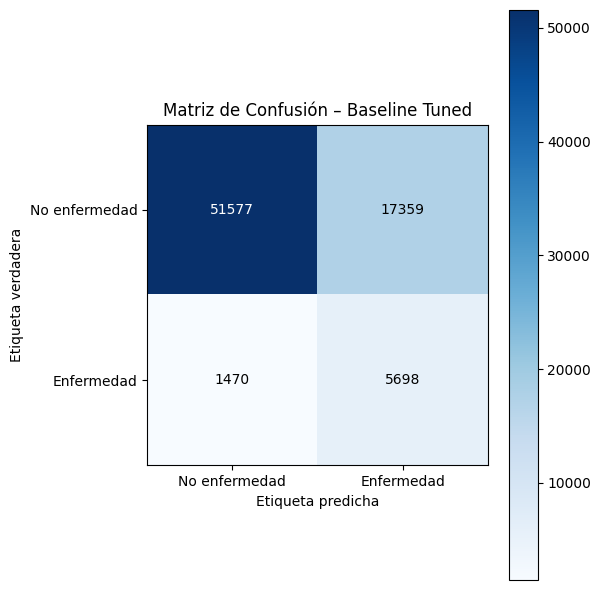

In [ ]:
from sklearn.model_selection import GridSearchCV

def ks_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, proba)
    return float(np.max(tpr - fpr))

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(
    LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ),
    param_grid,
    scoring=ks_scorer,    
    cv=3,
    n_jobs=-1,
    verbose=0
)

grid.fit(Xb_train, yb_train)

print("Mejor C:", grid.best_params_['C'])
print("Mejor KS (CV):", grid.best_score_)

best_baseline = grid.best_estimator_

y_pred_g  = best_baseline.predict(Xb_test)
y_proba_g = best_baseline.predict_proba(Xb_test)[:,1]
print("=== Modelo Optimo ===")
eval_model(yb_test, y_pred_g, y_proba_g)
plot_confusion_matrix(
    y_true=yb_test,
    y_pred=y_pred_g,
    classes=['No enfermedad','Enfermedad'],
    title='Matriz de Confusión – Baseline Tuned'
)

## Conclusiones del Modelo Final

### 1. parámetro óptimo  
- **C = 100** KS CV ≈ 0.545)

---

### 2. Evaluación en el conjunto de test  
| Métrica     | Valor      |  
|:------------|:-----------|  
| **Accuracy**  | 0.7526   |  
| **Precision** | 0.2471   |  
| **Recall**    | 0.7949   |  
| **ROC-AUC**   | 0.8485   |  
| **KS**        | 0.5446   |  

---

### 3. Matriz de confusión  
|                   | Predicción “No enfermedad” | Predicción “Enfermedad” |  
|:-----------------:|:-------------------------:|:-----------------------:|  
| **Real “No enfermedad”** | TN = 51 577                  | FP = 17 359               |  
| **Real “Enfermedad”**    | FN = 1 470                   | TP = 5 698                |  

- **TN (51 577):** Casos sanos correctamente identificados.  
- **FP (17 359):** Casos sanos etiquetados como enfermos (falsas alarmas).  
- **FN (1 470):** Pacientes enfermos no detectados (riesgo de “casos perdidos”).  
- **TP (5 698):** Pacientes enfermos correctamente detectados.

---

### 4. Interpretación y uso  
- El modelo logra **muy buena discriminación** (ROC-AUC ≈ 0.85) y un **KS** de 0.54, un valor considerado excelente en modelos de riesgo.  
- El **alto recall** (79.5 %) garantiza que detectamos la mayoría de los casos positivos, a costa de una **precisión** moderada (24.7 %). Esto es útil si se prioriza no dejar escapar pacientes con riesgo.  
- Si se quiere **reducir falsas alarmas**, se podría ajustar el umbral de decisión (aunque no está implementado en este notebook).

---